## Data Wrangling Notebook

### This notebook connects multiple auxiliary data sources with empirical data from RM283 (refer to relevant documentation for details)

#### Import packages for data wrangling and plotting

In [2]:
# import unctions for interacting with the operating system
import os
# import sys functions and variables to manipulate Python runtime environment
import sys
# import AWS SDK for Python
import boto3

In [3]:
%%capture
# mute output above
# install awswrangler package through url artifactory.foc.zone
!{sys.executable} -m pip install awswrangler --index-url https://private.artifactory.foc.zone/api/pypi/rdf-pypi-virtual/simple --extra-index-url https://private.artifactory.foc.zone/artifactory/api/pypi/pypi-remote/simple

In [4]:
# import awswrangler package
import awswrangler as wr
# import pandas for relational data analysis and manipulation
import pandas as pd
# import numpy to create and manipulate arrays
import numpy as np
# import date module to get current date
from datetime import date
# import matplotlib for plotting
import matplotlib.pyplot as plt

#### Create session to store configuration state and service clients

In [5]:
# create session and set environment variables
session = boto3.Session()
s3 = boto3.resource('s3')
wr.config.sts_endpoint_url = "https://sts." + session.region_name + ".amazonaws.com"
os.environ['AWS_DEFAULT_REGION'] = 'us-east-2' # specify your AWS region.

##### Enter experiment start date

In [6]:
# enter experiment start date
exp_start_date = '2022-06-21'
# identify current date
exp_curr_date = date.today()

#### Create parameterized query

In [163]:
def query_with_params(start_date = None, end_date = None, matchkey = None, table_name = None, limit = None):
    params = {
        "start_date": F"'{start_date}'",
        "end_date": F"'{end_date}'",
        "group_value_1": F"'{matchkey}'",
        "group_value_2": F"'%--{matchkey}%'",
        "group_value_3": F"'{matchkey}%'",
        "table_name": F"{table_name}",
        "limit": F"{limit}",
    }
    return params

In [179]:
def query_group_data(params = None):
    query = '''
        WITH groupData AS /*+label(query_data_rm283_visitors)*/
            (
        SELECT 
           mcvisid_visitorid,
           post_mvvar3,
           post_tnt,
           datekey,
           hour,
           visitnumber,
           visit_page_num,
           pagename,
        ROW_NUMBER() OVER 
        (
        PARTITION BY 
            mcvisid_visitorid
        ORDER BY 
            datekey DESC, 
            hour DESC, 
            visitnumber DESC, 
            visit_page_num DESC
        ) 
        AS rowNumber
        FROM :table_name;
        WHERE 
            (
            post_tnt= :group_value_1; 
            OR post_tnt LIKE :group_value_2; 
            OR post_tnt LIKE :group_value_3;) 
            AND datekey >= :start_date; 
            AND post_mvvar3 <> ''
            ),
        distinctVisitors AS
        (
        SELECT DISTINCT
           mcvisid_visitorid,
           post_tnt,
           datekey,
           hour
        FROM :table_name;
        WHERE 
            (
            post_tnt= :group_value_1; 
            OR post_tnt LIKE :group_value_2; 
            OR post_tnt LIKE :group_value_3;) 
            AND datekey >= :start_date;
            )
        SELECT 
           A.mcvisid_visitorid,
           A.post_mvvar3,
           A.post_tnt,
           A.datekey,
           A.hour,
           A.visitnumber,
           A.visit_page_num,
           A.pagename,
           A.rowNumber
        FROM groupData AS A
        INNER JOIN distinctVisitors ON
            A.mcvisid_visitorid = distinctVisitors.mcvisid_visitorid
        GROUP BY 
            A.mcvisid_visitorid,
            A.post_mvvar3,
            A.post_tnt,
            A.datekey,
            A.hour,
            A.visitnumber,
            A.visit_page_num,
            A.pagename,
            A.rowNumber
        LIMIT :limit;
        '''
    if params is not None:
        dataFrame = wr.athena.read_sql_query(sql = query, 
                                             database = "ktdp_model_outputs_raw_access", 
                                             params = params, 
                                             ctas_approach = False, 
                                             s3_output = "s3://sagemaker-us-east-2-780533714889/testwrangler",
                                             workgroup = 'rcd-datascientist',
                                             boto3_session = session)
        return dataFrame
    else:
        return None

#### Execute query for Control and Test group data

In [180]:
params_control = query_with_params(exp_start_date, 
                                   exp_curr_date, 
                                   matchkey = '562585:0:0', 
                                   table_name = 'rktdp_adobe_omniture_raw_processed_access.adobe_dq_prcd_data',
                                   limit = 'ALL',
                                  )
dataFrame_control = query_group_data(params_control)

In [9]:
params_test = query_with_params(exp_start_date, 
                                exp_curr_date, 
                                matchkey = '562585:1:0'
                                table_name = 'rktdp_adobe_omniture_raw_processed_access.adobe_dq_prcd_data'
                               )
dataFrame_test = query_group_data(params_test)

#### Verify data and plot distribution based on event clicks

In [10]:
print(dataFrame_control.shape, dataFrame_test.shape)

(182788, 9) (209562, 9)


In [11]:
print(dataFrame_control.mcvisid_visitorid.nunique())
print(dataFrame_test.mcvisid_visitorid.nunique())

7900
7424


In [12]:
def plot_histogram(x: list, y: list, nrows: int, ncols: int, xlabel: str, ylabel: str):
    # create subplots
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(8, 4))
    ax.hist([x, y], 
             bins='auto',
             range=(0, 70),
             stacked=False, 
             density=True,
             label=(str(xlabel), str(ylabel)))
    ax.legend(loc=(0.65, 0.8))
    ax.set_title('Distribution of $Control$ and $Test$ Observations by Visitor')
    ax.yaxis.tick_right()
    plt.show()

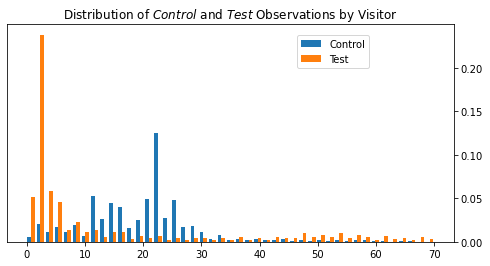

0
0


In [13]:
#dataFrame_control.drop_duplicates(subset=['mcvisid_visitorid'], inplace = True)
#dataFrame_test.drop_duplicates(subset=['mcvisid_visitorid'], inplace = True)
#dataFrame_control.drop_duplicates(subset=['mcvisid_visitorid'], inplace = False, keep='first')
#dataFrame_control.head(100)
control_events_freq = list(dataFrame_control.groupby('mcvisid_visitorid')['rowNumber'].max().values)
test_events_freq = list(dataFrame_test.groupby('mcvisid_visitorid')['rowNumber'].max().values)
test_events = dataFrame_test.groupby(['mcvisid_visitorid'], sort=False)['rowNumber'].max()
test_events = test_events.reset_index()
test_events.sort_values('rowNumber', inplace = True, ascending=False)
plot_histogram(control_events_freq, test_events_freq, nrows=1, ncols=1, xlabel='Control', ylabel='Test')
print(dataFrame_test[dataFrame_test['pagename'].str.contains('rocket:lander')].post_mvvar3.isna().sum())
print(dataFrame_control[dataFrame_control['pagename'].str.contains('rocket:lander')].post_mvvar3.isna().sum())
#TODO rocket:lander:bam orbit:nametimeframeToPurchase

#### Function to process retrieved data

In [14]:
def parse_string(dataFrame):
    # function parses string using regex to extract time to purchase values
    time_frame_regex = r'timeframetopurchase:(.*?)--|timeframetopurchase:([^.]*$)'
    dataFrame = (dataFrame.join(dataFrame['post_mvvar3'].str.extractall(time_frame_regex)[0].unstack().add_prefix('time_frame_to_purchase_start_')))
    dataFrame = (dataFrame.join(dataFrame['post_mvvar3'].str.extractall(time_frame_regex)[1].unstack().add_prefix('time_frame_to_purchase_end_')))
    parsed_columns = ['time_frame_to_purchase_start_0', 'time_frame_to_purchase_start_1', 'time_frame_to_purchase_start_2', 
           'time_frame_to_purchase_end_0', 'time_frame_to_purchase_end_1', 'time_frame_to_purchase_end_2']
    dataFrame_count = dataFrame.groupby('mcvisid_visitorid')[parsed_columns].apply(lambda x: pd.unique(x.values.ravel()).tolist()).reset_index(name='time_frame_to_purchase')
    dataFrame_count['time_frame_to_purchase_max_entry'] = pd.notna(dataFrame_count['time_frame_to_purchase'].values[0]).sum()
    dataFrame_merged = dataFrame.merge(dataFrame_count, on='mcvisid_visitorid', how='inner')
    dataFrame_merged.drop(parsed_columns, axis=1, inplace=True)
    #TODO: optimize inefficient retrieval and replacement of values
    for index, row in dataFrame_merged.iterrows():
        dataFrame_merged['time_frame_to_purchase_max_entry'].iloc[index] = pd.notna(dataFrame_merged['time_frame_to_purchase'].values[index]).sum()
        dataFrame_merged['time_frame_to_purchase'].iloc[index] = [y for y in row.time_frame_to_purchase if pd.notna(y)]
    
    return dataFrame_merged

In [15]:
# Filter records by 'timeframetopurchase' string in post_mvvar3
dataFrame_control = dataFrame_control[dataFrame_control['post_mvvar3'].str.contains('timeframetopurchase')]
dataFrame_test = dataFrame_test[dataFrame_test['post_mvvar3'].str.contains('timeframetopurchase')]
print(dataFrame_control.mcvisid_visitorid.nunique(), dataFrame_test.mcvisid_visitorid.nunique())
dataFrame_control_parsed = parse_string(dataFrame_control).copy()
dataFrame_test_parsed = parse_string(dataFrame_test).copy()
print(dataFrame_control_parsed.mcvisid_visitorid.nunique(), dataFrame_test_parsed.mcvisid_visitorid.nunique())

7899 7423


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


7899 7423


In [16]:
dataFrame_test_parsed[dataFrame_test_parsed['mcvisid_visitorid'] == '22452264393298590703697518714976847647']

,mcvisid_visitorid,post_mvvar3,post_tnt,datekey,hour,visitnumber,visit_page_num,pagename,rowNumber,time_frame_to_purchase,time_frame_to_purchase_max_entry
78043,22452264393298590703697518714976847647,timeframetopurchase:6+ months--**--timeframeto...,562585:1:0,2022-07-25,18,1,22,rocket:lander:wham orbit:workingWithAnAgent,1,"[6+ months, 2 - 3 months, 3 - 6 months]",3
78044,22452264393298590703697518714976847647,timeframetopurchase:6+ months--**--timeframeto...,562585:1:0,2022-07-25,18,1,21,rocket:lander:wham orbit:workingWithAnAgent,2,"[6+ months, 2 - 3 months, 3 - 6 months]",3


#### Concatenate test and control group processed data for export

In [71]:
# Concatenating two dataframes
df_write = pd.concat([dataFrame_control_parsed, dataFrame_test_parsed], keys=['control', 'test']).reset_index()
df_write = df_write.rename(columns={'level_0': 'group'})
df_write = df_write.drop('level_1', axis=1)
df_write.head()

,group,mcvisid_visitorid,post_mvvar3,post_tnt,datekey,hour,visitnumber,visit_page_num,pagename,rowNumber,time_frame_to_purchase_start_3,time_frame_to_purchase_end_3,time_frame_to_purchase,time_frame_to_purchase_max_entry
0,control,00661035565934192173447413953129208282,purpose:purchase--**--homedescription:multifam...,562585:0:0,2022-06-22,8,1,16,rocket:lander:wham orbit:name,1,<NA>,<NA>,[3 - 6 months],1
1,control,00661035565934192173447413953129208282,purpose:purchase--**--homedescription:multifam...,562585:0:0,2022-06-22,8,1,15,rocket:lander:wham orbit:bankruptcy,2,<NA>,<NA>,[3 - 6 months],1
2,control,00661035565934192173447413953129208282,purpose:purchase--**--homedescription:multifam...,562585:0:0,2022-06-22,8,1,14,rocket:lander:wham orbit:foreclosure,3,<NA>,<NA>,[3 - 6 months],1
3,control,00661035565934192173447413953129208282,purpose:purchase--**--homedescription:multifam...,562585:0:0,2022-06-22,8,1,13,rocket:lander:wham orbit:latePayments,4,<NA>,<NA>,[3 - 6 months],1
4,control,00661035565934192173447413953129208282,purpose:purchase--**--homedescription:multifam...,562585:0:0,2022-06-22,8,1,12,rocket:lander:wham orbit:employmentStatus,5,<NA>,<NA>,[3 - 6 months],1


#### Export processed data as .csv to S3 Bucket

In [ ]:
# Write dataframe to s3
bucket = 'sagemaker-us-east-2-534295958235'
prefix = 'rm283'
path = f's3://{bucket}/{prefix}/adobe_dq_prcd_clickstream_data_parsed.csv'
print(path)
#df = dd.from_pandas(df, npartitions=N)
df_write.to_csv(path, index=False)

s3://sagemaker-us-east-2-534295958235/rm283/adobe_dq_prcd_clickstream_data_parsed.csv


#### Import processed data from S3 Bucket as Dataframe

In [25]:
import ast
import_data_csv = wr.s3.read_csv(path=path, converters={'time_frame_to_purchase': ast.literal_eval})
import_data_csv = import_data_csv.rename(columns={'level_0': 'group'})
import_data_csv.mcvisid_visitorid.nunique()

/opt/conda/lib/python3.8/site-packages/awswrangler/s3/_read_text.py:155: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  ret = _read_text_file(


15322

#### Split imported data into Test and Control Groups

In [26]:
dataFrame_control_parsed = import_data_csv[import_data_csv['group'] == 'control'].reset_index()
dataFrame_test_parsed = import_data_csv[import_data_csv['group'] == 'test'].reset_index()
dataFrame_control_parsed.sort_values('rowNumber', ascending = True, inplace = True)
#dataFrame_control_parsed = dataFrame_control[dataFrame_control['pagename'].str.contains('rocket:lander:')]
dataFrame_test_parsed.sort_values('rowNumber', ascending = True, inplace = True)
#dataFrame_test_parsed = dataFrame_test[dataFrame_test['pagename'].str.contains('rocket:lander:')]
dataFrame_test_parsed.head()

,index,group,mcvisid_visitorid,post_mvvar3,post_tnt,datekey,hour,visitnumber,visit_page_num,pagename,rowNumber,time_frame_to_purchase_start_3,time_frame_to_purchase_end_3,time_frame_to_purchase,time_frame_to_purchase_max_entry
0,167607,test,03199338292631991111505791365264221962,hasrealestateagent:no--**--purpose:purchase--*...,562585:1:0,2022-07-20,16,1,16,rocket:account:create account,1,NaN,NaN,[3 - 6 months],1
109542,277149,test,85645577091390505840298276006001492690,purpose:purchase--**--homedescription:multifam...,562585:1:0,2022-06-23,17,1,16,rocket:account:create account,1,NaN,NaN,[no time frame; i am researching options],1
109462,277069,test,80313126566251095050957387026121839731,purpose:purchase--**--homedescription:singlefa...,557633:1:0--**--558981:1:0--**--558117:0:0--**...,2022-07-20,13,4,136,rocket:application:purchase:apply:fund options,1,NaN,NaN,[3 - 6 months],1
109414,277021,test,23422778602752106331242984109589795770,hasrealestateagent:no--**--purpose:purchase--*...,562585:1:0,2022-06-22,17,1,14,rocket:lander:wham orbit:military,1,NaN,NaN,[no time frame; i am researching options],1
109412,277019,test,23218557796228317312589868197175201338,purpose:purchase--**--homedescription:singlefa...,562585:1:0,2022-06-23,13,1,8,rocket:lander:wham orbit:workingWithAnAgent,1,NaN,NaN,[3 - 6 months],1


#### Verify integrity of the imported data

In [27]:
dataFrame_test_parsed[dataFrame_test_parsed['mcvisid_visitorid'] == '46699317916047119862692951019342036718']['time_frame_to_purchase'].explode().value_counts()

within 30 days                             128
no time frame; i am researching options    128
Name: time_frame_to_purchase, dtype: int64

In [28]:
dataFrame_control_indecisive = dataFrame_control_parsed[dataFrame_control_parsed.groupby(['mcvisid_visitorid'])['time_frame_to_purchase_max_entry'].transform('max') > 1]
dataFrame_test_indecisive = dataFrame_test_parsed[dataFrame_test_parsed.groupby(['mcvisid_visitorid'])['time_frame_to_purchase_max_entry'].transform('max') > 1]
print(dataFrame_control_indecisive['mcvisid_visitorid'].nunique(), dataFrame_test_indecisive['mcvisid_visitorid'].nunique())

243 280


In [29]:
dataFrame_control_decisive = dataFrame_control_parsed[dataFrame_control_parsed.groupby(['mcvisid_visitorid'])['time_frame_to_purchase_max_entry'].transform('max') == 1]
dataFrame_test_decisive = dataFrame_test_parsed[dataFrame_test_parsed.groupby(['mcvisid_visitorid'])['time_frame_to_purchase_max_entry'].transform('max') == 1]
#print(dataFrame_control_decisive.shape, dataFrame_test_decisive.shape)
print(dataFrame_control_decisive['mcvisid_visitorid'].nunique(), dataFrame_test_decisive['mcvisid_visitorid'].nunique())

7656 7143


In [30]:
print(dataFrame_control_indecisive['mcvisid_visitorid'].nunique() + dataFrame_control_decisive['mcvisid_visitorid'].nunique(), 
      dataFrame_test_indecisive['mcvisid_visitorid'].nunique() + dataFrame_test_decisive['mcvisid_visitorid'].nunique())

7899 7423


In [31]:
print(dataFrame_control_parsed.mcvisid_visitorid.nunique())
print(dataFrame_test_parsed.mcvisid_visitorid.nunique())

7899
7423


In [32]:
dataFrame_control_parsed.drop_duplicates(subset=['mcvisid_visitorid'], inplace = True, keep='first')
dataFrame_test_parsed.drop_duplicates(subset=['mcvisid_visitorid'], inplace = True, keep='first')
print(dataFrame_control_parsed.shape, dataFrame_test_parsed.shape)

(7899, 15) (7423, 15)


In [33]:
print("Total visitors included in experiment:", dataFrame_control_parsed.shape[0] + dataFrame_test_parsed.shape[0])

Total visitors included in experiment: 15322


In [34]:
dataFrame_test_parsed[dataFrame_test_parsed['mcvisid_visitorid'] == '46699317916047119862692951019342036718'].time_frame_to_purchase.explode().value_counts()

within 30 days                             1
no time frame; i am researching options    1
Name: time_frame_to_purchase, dtype: int64

In [35]:
dataFrame_test_parsed[dataFrame_test_parsed['mcvisid_visitorid'] == '46699317916047119862692951019342036718']

,index,group,mcvisid_visitorid,post_mvvar3,post_tnt,datekey,hour,visitnumber,visit_page_num,pagename,rowNumber,time_frame_to_purchase_start_3,time_frame_to_purchase_end_3,time_frame_to_purchase,time_frame_to_purchase_max_entry
82947,250554,test,46699317916047119862692951019342036718,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:0:0,2022-07-01,18,2,56,rocket:lander:wham orbit:addressAndZip,1,NaN,NaN,"[within 30 days, no time frame; i am researchi...",2


In [36]:
print(dataFrame_test_parsed.iloc[500].post_mvvar3)
print(dataFrame_test_parsed.iloc[500].mcvisid_visitorid)

hasrealestateagent:no--**--purpose:purchase--**--homedescription:singlefamily--**--propertyuse:primaryresidence--**--timeframetopurchase:no time frame; i am researching options--**--firsttimebuyer:yes--**--military:no--**--timeframetobuy:looking at homes and listings--**--timeframetobuylooking:buying in 6+ months--**--livingsituationtype:renter--**--monthlyrent:$765--**--occupancystart-month:2--**--occupancystart-year:2016--**--maritalstatus:single--**--militaryservice:false--**--purchaseplans:false--**--homeuse:primary--**--mixeduseproperty:false--**--minimumhomeprice:$300,000--**--hasrealestateagent:false--**--downpaymentassistanceamount:$3,000--**--assetallocation:$4,000--**--socialsecurityannualincome0:$9,972--**--residencefor:true--**--ownership:false--**--downpayment:false--**--othermortgage:false--**--newcredit:false--**--legalpayments:false--**--cosign:false--**--judgments:false--**--payment:false--**--lawsuit:false--**--bankruptcy:false--**--citizenship:true
235378723911206635

#### Determine distribution of visitors by time frame

In [53]:
dataFrame_test_decisive.drop_duplicates(subset=['mcvisid_visitorid'], keep='first').time_frame_to_purchase.explode().value_counts()

no time frame; i am researching options    4939
6+ months                                  1317
3 - 6 months                                887
Name: time_frame_to_purchase, dtype: int64

In [59]:
dataFrame_test_indecisive.drop_duplicates(subset=['mcvisid_visitorid'], keep='first').time_frame_to_purchase.explode().value_counts()

no time frame; i am researching options     209
6+ months                                   115
3 - 6 months                                 98
2 - 3 months                                 85
within 30 days                               43
asap: found a house/offer pending            20
immediately: signed a purchase agreement      7
Name: time_frame_to_purchase, dtype: int64

In [60]:
dataFrame_control_decisive.drop_duplicates(subset=['mcvisid_visitorid'], keep='first').time_frame_to_purchase.explode().value_counts()

no time frame; i am researching options    5350
6+ months                                  1376
3 - 6 months                                930
Name: time_frame_to_purchase, dtype: int64

In [61]:
dataFrame_control_indecisive.drop_duplicates(subset=['mcvisid_visitorid'], keep='first').time_frame_to_purchase.explode().value_counts()

no time frame; i am researching options     199
6+ months                                    91
3 - 6 months                                 66
2 - 3 months                                 63
within 30 days                               44
asap: found a house/offer pending            26
immediately: signed a purchase agreement     13
Name: time_frame_to_purchase, dtype: int64

In [62]:
dataFrame_test_parsed.iloc[138].post_mvvar3

'timeframetopurchase:3 - 6 months--**--sharemydata:on--**--timeframetobuy:looking at homes and listings--**--timeframetobuylooking:buying in 3 to 6 months--**--livingsituationtype:renter--**--monthlyrent:$236--**--occupancystart-month:7--**--occupancystart-year:2017--**--maritalstatus:single--**--militaryservice:false--**--purchaseplans:true--**--kindofhome:singlefamily--**--homeprice:$400,000--**--homeuse:investment--**--hasrealestateagent:false--**--purpose:purchase--**--homedescription:singlefamily--**--propertyuse:investmentproperty--**--timeframetopurchase:6+ months--**--firsttimebuyer:yes--**--military:no--**--hasrealestateagent:no--**--purchaseprice:400,000--**--downpayment:15,000--**--creditrating:580-619--**--creditratingdescription:below average--**--employmentstatus:retired--**--bankruptcy:no'

In [63]:
dataFrame_test_parsed['time_frame_to_purchase'].explode().value_counts()

no time frame; i am researching options     5148
6+ months                                   1432
3 - 6 months                                 985
2 - 3 months                                  85
within 30 days                                43
asap: found a house/offer pending             20
immediately: signed a purchase agreement       7
Name: time_frame_to_purchase, dtype: int64

In [65]:
dataFrame_test_parsed['time_frame_to_purchase'].isnull().values.any().sum()

0

In [77]:
dataFrame_test_decisive[dataFrame_test_decisive.explode('time_frame_to_purchase')['time_frame_to_purchase'] == '3 - 6 months']

,index,group,mcvisid_visitorid,post_mvvar3,post_tnt,datekey,hour,visitnumber,visit_page_num,pagename,rowNumber,time_frame_to_purchase_start_3,time_frame_to_purchase_end_3,time_frame_to_purchase,time_frame_to_purchase_max_entry
0,167607,test,03199338292631991111505791365264221962,hasrealestateagent:no--**--purpose:purchase--*...,562585:1:0,2022-07-20,16,1,16,rocket:account:create account,1,NaN,NaN,[3 - 6 months],1
109462,277069,test,80313126566251095050957387026121839731,purpose:purchase--**--homedescription:singlefa...,557633:1:0--**--558981:1:0--**--558117:0:0--**...,2022-07-20,13,4,136,rocket:application:purchase:apply:fund options,1,NaN,NaN,[3 - 6 months],1
109412,277019,test,23218557796228317312589868197175201338,purpose:purchase--**--homedescription:singlefa...,562585:1:0,2022-06-23,13,1,8,rocket:lander:wham orbit:workingWithAnAgent,1,NaN,NaN,[3 - 6 months],1
109387,276994,test,20891911559505541144107500658424309592,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:1:0,2022-06-23,4,2,32,rocket:application:purchase:current home:previ...,1,NaN,NaN,[3 - 6 months],1
109384,276991,test,20570986169964320883645582462656767652,purpose:purchase--**--homedescription:singlefa...,562585:1:0,2022-06-26,11,1,18,rocket:account:create account,1,NaN,NaN,[3 - 6 months],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105549,273156,test,30506138026453893730640745371215107693,purpose:purchase--**--homedescription:singlefa...,562032:1:0--**--562585:1:0,2022-07-10,15,2,11,rocket:dashboard:home,385,NaN,NaN,[3 - 6 months],1
105550,273157,test,30506138026453893730640745371215107693,purpose:purchase--**--homedescription:singlefa...,562032:1:0--**--562585:1:0,2022-07-10,15,2,10,rocket:account:create account,386,NaN,NaN,[3 - 6 months],1
105551,273158,test,30506138026453893730640745371215107693,purpose:purchase--**--homedescription:singlefa...,562032:1:0--**--562585:1:0,2022-07-10,15,2,9,rocket:account:create account,387,NaN,NaN,[3 - 6 months],1
105552,273159,test,30506138026453893730640745371215107693,purpose:purchase--**--homedescription:singlefa...,562032:1:0--**--562585:1:0,2022-07-10,15,2,8,rocket:account:create account,388,NaN,NaN,[3 - 6 months],1


In [79]:
dataFrame_test_indecisive[dataFrame_test_indecisive['mcvisid_visitorid'] == '11494568057096150222166659886862572167']

,index,group,mcvisid_visitorid,post_mvvar3,post_tnt,datekey,hour,visitnumber,visit_page_num,pagename,rowNumber,time_frame_to_purchase_start_3,time_frame_to_purchase_end_3,time_frame_to_purchase,time_frame_to_purchase_max_entry
175885,343492,test,11494568057096150222166659886862572167,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:1:0,2022-07-15,3,2,42,rocket:opt out,1,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
175886,343493,test,11494568057096150222166659886862572167,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:1:0,2022-07-15,3,2,41,rocket:opt out,2,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
175887,343494,test,11494568057096150222166659886862572167,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:1:0,2022-07-15,3,2,40,rocket:opt out,3,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
175888,343495,test,11494568057096150222166659886862572167,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:1:0,2022-07-15,3,2,39,rocket:thank you:lander:thank you,4,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
175889,343496,test,11494568057096150222166659886862572167,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:1:0,2022-07-15,3,2,38,rocket:thank you:lander:thank you,5,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175950,343557,test,11494568057096150222166659886862572167,timeframetopurchase:asap: found a house/offer ...,562585:1:0,2022-06-22,18,1,27,rocket:account:create account,72,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
175951,343558,test,11494568057096150222166659886862572167,timeframetopurchase:asap: found a house/offer ...,562585:1:0,2022-06-22,18,1,26,rocket:account:create account,73,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
175952,343559,test,11494568057096150222166659886862572167,timeframetopurchase:asap: found a house/offer ...,562585:1:0,2022-06-22,18,1,24,rocket:lander:wham orbit:military,74,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3
175953,343560,test,11494568057096150222166659886862572167,timeframetopurchase:asap: found a house/offer ...,562585:1:0,2022-06-22,18,1,23,rocket:lander:wham orbit:firstTimeHomeBuyer,75,NaN,NaN,"[2 - 3 months, asap: found a house/offer pendi...",3


In [81]:
dataFrame_test_parsed[dataFrame_test_parsed['mcvisid_visitorid'] == '46699317916047119862692951019342036718']

,index,group,mcvisid_visitorid,post_mvvar3,post_tnt,datekey,hour,visitnumber,visit_page_num,pagename,rowNumber,time_frame_to_purchase_start_3,time_frame_to_purchase_end_3,time_frame_to_purchase,time_frame_to_purchase_max_entry
82947,250554,test,46699317916047119862692951019342036718,purpose:purchase--**--homedescription:singlefa...,562585:1:0--**--562432:0:0,2022-07-01,18,2,56,rocket:lander:wham orbit:addressAndZip,1,NaN,NaN,"[within 30 days, no time frame; i am researchi...",2


#### Secondary query to retireve data by mcvisid_visitorid

In [296]:
query = '''SELECT  
       adp.mcvisid_visitorid,
       adp.post_tnt,
       adp.datekey,
       post_mvvar3,
       adp.hour,
       adp.visitnumber,
       adp.visit_page_num,
       adp.pagename
FROM rktdp_adobe_omniture_raw_processed_access.adobe_dq_prcd_data AS adp
WHERE (post_tnt='562585:1:0' OR post_tnt LIKE '%--562585:1:0%' OR post_tnt LIKE '562585:1:0%') AND datekey>='2022-06-21' AND mcvisid_visitorid = '52716069707398030873258455077810037767' 
ORDER BY adp.datekey DESC, adp.hour DESC, adp.visitnumber DESC, adp.visit_page_num DESC
'''
df = wr.athena.read_sql_query(sql=query, database="rktdp_adobe_omniture_raw_processed_access", ctas_approach=False, 
                              workgroup='rcd-datascientist')

In [179]:
print(df.isna().sum())
df.tail(10)

mcvisid_visitorid    0
post_tnt             0
datekey              0
post_mvvar3          7
hour                 0
visitnumber          0
visit_page_num       0
pagename             0
dtype: int64


,mcvisid_visitorid,post_tnt,datekey,post_mvvar3,hour,visitnumber,visit_page_num,pagename
132,46699317916047119862692951019342036718,562585:1:0--**--562432:0:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,20,rocket:application:purchase:current home
133,46699317916047119862692951019342036718,562585:1:0--**--562432:0:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,19,rocket:application:purchase:current home
134,46699317916047119862692951019342036718,562585:1:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,18,rocket:dashboard:home
135,46699317916047119862692951019342036718,562585:1:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,17,rocket:dashboard:home
136,46699317916047119862692951019342036718,562585:1:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,16,rocket:account:create account
137,46699317916047119862692951019342036718,562585:1:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,15,rocket:account:create account
138,46699317916047119862692951019342036718,562585:1:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,14,rocket:account:create account
139,46699317916047119862692951019342036718,562585:1:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,13,rocket:lander:wham orbit:workingWithAnAgent
140,46699317916047119862692951019342036718,562585:1:0,2022-06-23,hasrealestateagent:no--**--purpose:purchase--*...,15,1,12,rocket:lander:wham orbit:military
141,46699317916047119862692951019342036718,562585:1:0,2022-06-23,purpose:purchase--**--homedescription:singlefa...,15,1,11,rocket:lander:wham orbit:workingWithAnAgent


In [177]:
df[df['pagename'].str.contains('rocket:lander')].post_mvvar3.iloc[-1]

'purpose:purchase--**--homedescription:singlefamily--**--propertyuse:secondaryhome--**--timeframetopurchase:no time frame; i am researching options--**--firsttimebuyer:no--**--military:no--**--hasrealestateagent:no'

In [100]:
df[df['pagename'].str.contains('rocket:lander')].post_mvvar3.isna().sum()

0

In [153]:
time_frame_regex = 'timeframetopurchase(.*?)--'
df['time_frame_to_purchase'] = df.post_mvvar3.str.extract(time_frame_regex, expand=False)

In [155]:
df.iloc[0]['post_mvvar3']

'hasrealestateagent:no--**--purpose:purchase--**--homedescription:singlefamily--**--propertyuse:secondaryhome--**--timeframetopurchase:3 - 6 months--**--firsttimebuyer:no--**--military:no'

In [156]:
df['time_frame_to_purchase'].value_counts()

:3 - 6 months    4
Name: time_frame_to_purchase, dtype: Int64

In [151]:
df['post_mvvar3'].iloc[-5]

'purpose:purchase--**--homedescription:singlefamily--**--propertyuse:primaryresidence--**--timeframetopurchase:2 - 3 months--**--firsttimebuyer:yes--**--military:no--**--hasrealestateagent:no--**--purchaseprice:100,000--**--downpayment:0--**--creditrating:620-659--**--creditratingdescription:average--**--employmentstatus:employed--**--bankruptcy:no'

In [34]:
df.post_mvvar3.str.extract(time_frame_regex, expand=False).unique()

<StringArray>
[':asap: found a house/offer pending', <NA>, ':2 ']
Length: 3, dtype: string